In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm


import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

In [2]:

print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())

2.2.2+cu118 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [3]:
device= 'cuda'

The potential function its gradient with respect to x is given by:
$$V(x, y) = 3e^{-x^2 - (y - \frac{1}{3})^2} - 3e^{-x^2 - (y - \frac{5}{3})^2}
         - 5e^{-(x - 1)^2 - y^2} - 5e^{-(x + 1)^2 - y^2}
         + \frac{2}{10}x^4 + \frac{2}{10}(y - \frac{1}{3})^4$$
$$\frac{\partial V}{\partial x} = -6xe^{-x^2-(y-\frac{1}{3})^2} + 6xe^{-x^2-(y-\frac{5}{3})^2} + 10(x-1)e^{- (x-1)^2 - y^2} + 10(x+1)e^{- (x+1)^2 - y^2} + \frac{8}{10}x^3$$
$$\frac{\partial V}{\partial y} = -6(y-\frac{1}{3})e^{-x^2-(y-\frac{1}{3})^2} + 6(y-\frac{5}{3})e^{-x^2-(y-\frac{5}{3})^2} + 10ye^{-(x-1)^2-y^2} + 10ye^{-(x+1)^2-y^2} + \frac{8}{10}(y - \frac{1}{3})^3$$

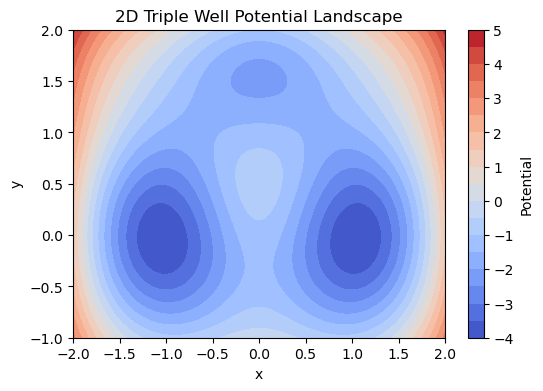

In [4]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

# Calculate the potential at each point
Z = potential(X, Y)

# Plot the potential landscape
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
plt.title('2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

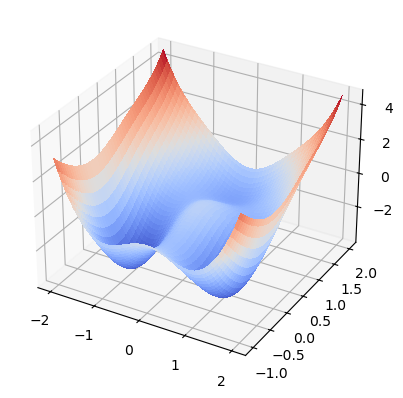

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.contourf(x, y, V, levels=np.linspace(-4.5, 4.5, 20), cmap='coolwarm');
# plt.grid()
surf = ax.plot_surface(X, Y,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [6]:
## Generate a single trajectory in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 500  # Number of evaluations
lag_time = h * n_steps  # Lag time for each evolution

# Set the initial position
x0 = 0.0
y0 = 0.0

# Set the diffusion coefficient
sigma = 1.09

# Generate the trajectory
x_traj = [x0]
y_traj = [y0]
x = x0
y = y0

for i in tqdm (range(n_eval)):
    for j in range(n_steps):
        dVdx, dVdy = gradient(x, y)
        x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
        y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()
    x_traj.append(x)
    y_traj.append(y)

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

# Calculate the potential at each point
Z = potential(X, Y)

100%|██████████| 500/500 [00:00<00:00, 590.49it/s]


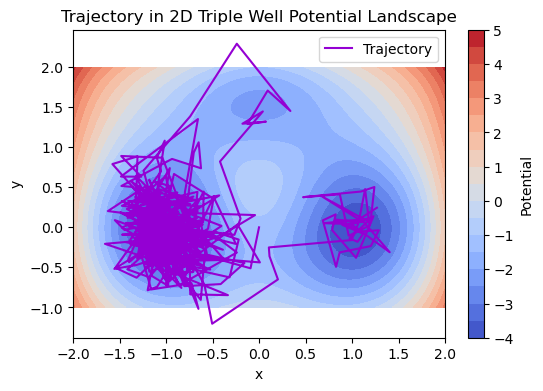

In [7]:
# Plot the potential landscape and the trajectory
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
plt.plot(x_traj, y_traj, color= 'darkviolet', linewidth=1.5, label='Trajectory')
plt.title('Trajectory in 2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [8]:
## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 40

# Set the diffusion coefficient
sigma = 1.09

# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 1600/1600 [00:29<00:00, 53.94it/s]


In [9]:
#data_matrix[:, :, 0].ravel()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.22054108, -2.19910721, -2.17767335, -2.15623948, -2.13480561,
        -2.11337174, -2.09193787, -2.07050401, -2.04907014, -2.02763627,
        -2.0062024 , -1.98476853, -1.96333467, -1.9419008 , -1.92046693,
        -1.89903306, -1.8775992 , -1.85616533, -1.83473146, -1.81329759,
        -1.79186372, -1.77042986, -1.74899599, -1.72756212, -1.70612825,
        -1.68469438, -1.66326052, -1.64182665, -1.62039278, -1.59895891,
        -1.57752504, -1.55609118, -1.53465731, -1.51322344, -1.49178957,
        -1.4703557 , -1.44892184, -1.42748797, -1.4060541 , -1.38462023,
        -1.36318636, -1.3417525 , -1.32031863, -1.29888476, -1.27745089,
        -1.25601703, -1.23458316, -1.21314929, -1.19171542, -1.17028155,
        -1.14884769, 

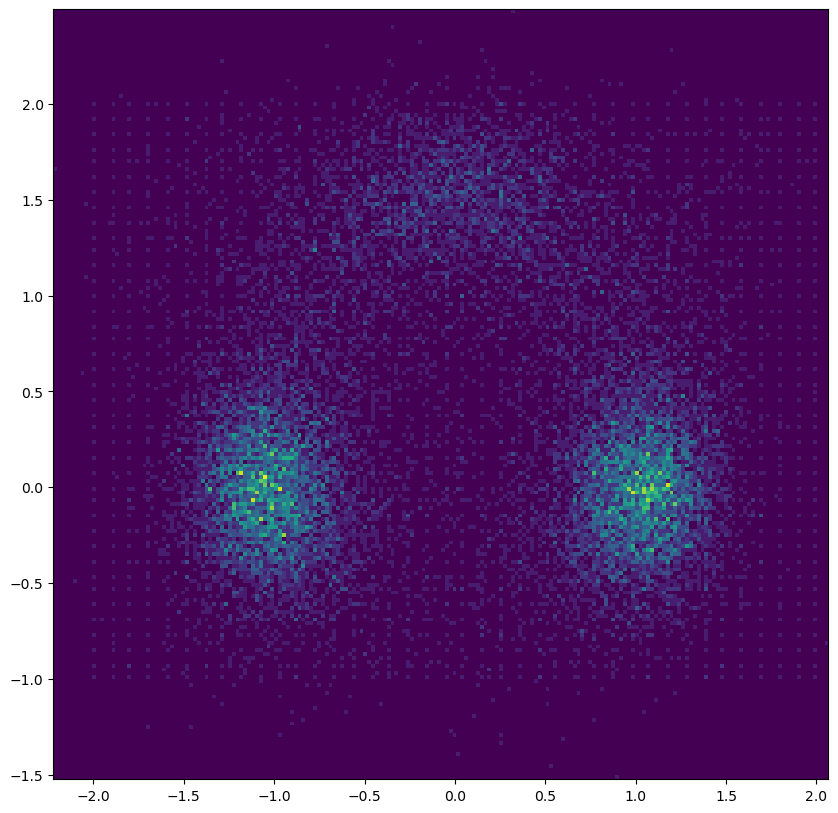

In [10]:
fig2, ax2= plt.subplots(figsize= (10,10))
ax2.hist2d (data_matrix[:, :, 0].ravel(), data_matrix[:, :, 1].ravel(), bins= 200)


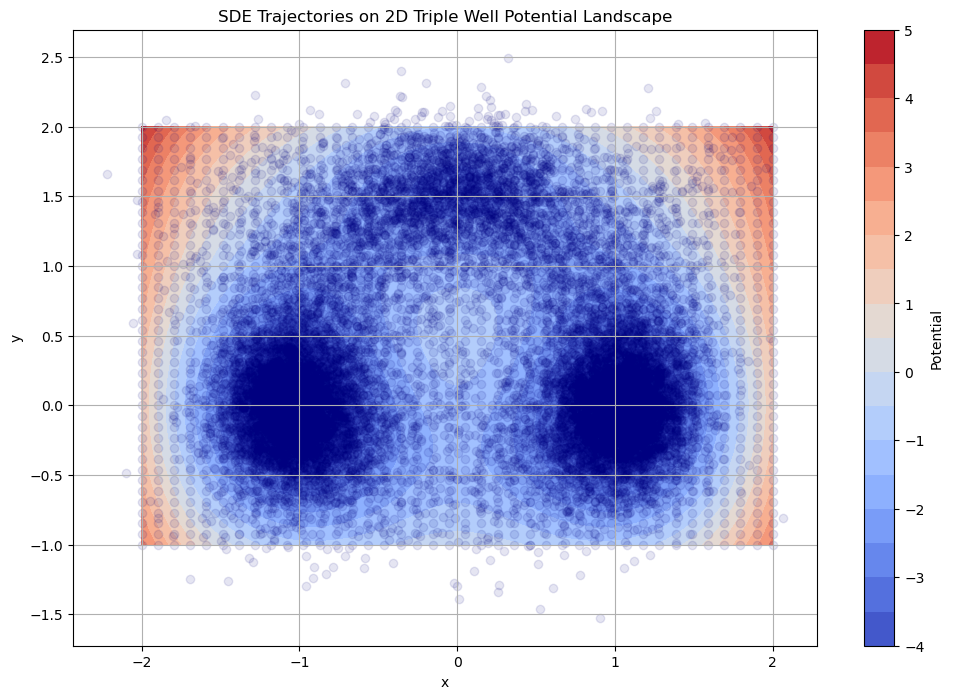

Shape of data_matrix: (1600, 11, 2)


In [11]:
# Calculate the potential at each point
Z = potential(X, Y)

# Plot the potential landscape and the trajectories
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
for ii in range(m**2):
    plt.scatter(data_matrix[ii, :, 0], data_matrix[ii, :, 1], color= 'navy', alpha=0.1)
plt.title('SDE Trajectories on 2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

print("Shape of data_matrix:", data_matrix.shape)

In [12]:
## Save the data to local folder

# Create a folder to store the data (if it doesn't exist)
folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

# Save the data_matrix to a file
file_path = os.path.join(folder_path, "triple_well_2d.npy")
np.save(file_path, data_matrix)

In [13]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, "triple_well_2d.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(1600, 11, 2)

In [14]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of data_X: (1600, 10, 2)
Shape of data_Y: (1600, 10, 2)
Shape of X: (16000, 2)
Shape of Y: (16000, 2)


In [15]:
n_debug= 2000
# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train00 = X[:int(0.7*len_all)]
data_x_valid00 = X[int(0.7*len_all)+1:]

data_y_train00 = Y[:int(0.7*len_all)]
data_y_valid00 = Y[int(0.7*len_all)+1:]

data_x_train= data_x_train00[:n_debug, :]
data_y_train= data_y_train00[:n_debug, :]

data_x_valid= data_x_valid00[:n_debug, :]
data_y_valid= data_y_valid00[:n_debug, :]


data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

(2000, 2)


In [16]:
data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [17]:
checkpoint_file= 'well2d_example_ckpt004.torch'

In [18]:
basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[30], n_psi_train=27).to(device)  # basis number would be 20

In [19]:
solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

In [20]:
# # Compute the drift and diffusion terms
# #b_Xt, a_Xt = solver.compute_var_coefficients(data_x_train_tensor)
# b_Xt, a_Xt = solver.compute_neural_a_b(data_x_train_tensor)
# print("\nDrift term (b_Xt):")
# print(b_Xt.detach().shape)
# print(b_Xt.detach().cpu().numpy())
# print("\nDiffusion term (a_Xt):")
# print(a_Xt.shape)
# print(a_Xt.detach().cpu().numpy())

In [21]:
# # Compute L_Psi
# L_Psi = solver.compute_generator_L(data_x_train_tensor, b_Xt, a_Xt)

# print("\nL_Psi:")
# print(L_Psi.shape)
# print(L_Psi.detach().cpu().numpy())


In [22]:
# # Calculate the eigenvalues of L_Psi
# eigenvalues =torch.linalg.eig(L_Psi)[0]
# # Extract real parts of the eigenvalues
# real_parts =eigenvalues.real
# # Get the indices that would sort the real parts in descending order
# sorted_indices = torch.argsort(real_parts, descending= True)
# # Use the indices to sort the entire eigenvalues array
# sorted_eigenvalues =eigenvalues[sorted_indices]#torch.gather(eigenvalues, sorted_indices)

# print("\nEigenvalues of L_Psi:")
# print(sorted_eigenvalues.shape)
# print(sorted_eigenvalues.detach().cpu().numpy())

In [23]:

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=30,
    batch_size=256,
    lr=1e-4,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 1.039792 val loss: 1.053935
saving, val loss enhanced: 1.0539353071583446 10000
Epoch: 2 	Training Loss: 1.022309 val loss: 1.038659
saving, val loss enhanced: 1.0386587739463151 1.0539353071583446
Epoch: 3 	Training Loss: 1.005182 val loss: 1.022121
saving, val loss enhanced: 1.0221211362477824 1.0386587739463151
Epoch: 4 	Training Loss: 0.993149 val loss: 1.011468
saving, val loss enhanced: 1.0114684102590237 1.0221211362477824
Epoch: 5 	Training Loss: 0.981975 val loss: 0.996786
saving, val loss enhanced: 0.9967862696052653 1.0114684102590237
Epoch: 6 	Training Loss: 0.964188 val loss: 0.984931
saving, val loss enhanced: 0.9849305272806267 0.9967862696052653
Epoch: 7 	Training Loss: 0.952159 val loss: 0.970954
saving, val loss enhanced: 0.970954390758663 0.9849305272806267
Epoch: 8 	Training Loss: 0.940521 val loss: 0.956341
saving, val loss enhanced: 0.9563411017443565 0.970954390758663
Epoch: 9 	Training Loss: 0.927941 val loss: 0.945217
saving, val loss e

Computing dPsi_X: 100%|██████████| 59970/59970 [00:18<00:00, 3187.01iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Outer Epoch 1/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:18<00:00, 3170.39iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1578111.176388 val loss: 2094824.362959
saving, val loss enhanced: 2094824.362958806 1000000000000000.0
Epoch: 2 	Training Loss: 1493661.880780 val loss: 2032645.399466
saving, val loss enhanced: 2032645.3994664603 2094824.362958806
Epoch: 3 	Training Loss: 1415834.079437 val loss: 1973318.600748
saving, val loss enhanced: 1973318.6007481425 2032645.3994664603
Epoch: 4 	Training Loss: 1344427.644322 val loss: 1916417.463395
saving, val loss enhanced: 1916417.4633953008 1973318.6007481425
Epoch 1 time: 49.31 seconds
Outer Epoch 2/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:19<00:00, 3029.66iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1584979.233435 val loss: 2932361.325651
Epoch: 2 	Training Loss: 1523808.992557 val loss: 2840940.024753
Epoch: 3 	Training Loss: 1465420.495624 val loss: 2747475.629424
Epoch: 4 	Training Loss: 1410740.641920 val loss: 2655290.841000
Epoch 2 time: 31.38 seconds
Outer Epoch 3/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:19<00:00, 3061.72iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1784496.582695 val loss: 3585044.030113
Epoch: 2 	Training Loss: 1713380.490084 val loss: 3428246.438521
Epoch: 3 	Training Loss: 1643420.542987 val loss: 3275099.817694
Epoch: 4 	Training Loss: 1577226.581424 val loss: 3129250.554906
Epoch 3 time: 64.83 seconds
Outer Epoch 4/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:19<00:00, 3029.68iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1549590.686351 val loss: 3281723.461985
Epoch: 2 	Training Loss: 1487009.045258 val loss: 3132103.275109
Epoch: 3 	Training Loss: 1427662.140444 val loss: 2989539.149685
Epoch: 4 	Training Loss: 1371589.170989 val loss: 2854356.321325
Epoch 4 time: 70.21 seconds
Outer Epoch 5/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:19<00:00, 3052.66iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1085267.953157 val loss: 2293727.175725
Epoch: 2 	Training Loss: 1044703.335634 val loss: 2192950.677309
Epoch: 3 	Training Loss: 1006319.410258 val loss: 2098243.372806
Epoch: 4 	Training Loss: 970173.937745 val loss: 2009189.411857
Epoch 5 time: 204.46 seconds
Outer Epoch 6/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:23<00:00, 2586.24iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 576649.333214 val loss: 546393.012923
saving, val loss enhanced: 546393.0129233731 1916417.4633953008
Epoch: 2 	Training Loss: 559089.295146 val loss: 527621.185271
saving, val loss enhanced: 527621.1852708731 546393.0129233731
Epoch: 3 	Training Loss: 542817.084097 val loss: 510959.538000
saving, val loss enhanced: 510959.5380004881 527621.1852708731
Epoch: 4 	Training Loss: 527292.300754 val loss: 495450.802722
saving, val loss enhanced: 495450.80272164935 510959.5380004881
Epoch 6 time: 43.99 seconds
Outer Epoch 7/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:20<00:00, 2855.94iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 405556.568499 val loss: 706706.617541
Epoch: 2 	Training Loss: 391329.372891 val loss: 691022.976542
Epoch: 3 	Training Loss: 375950.706437 val loss: 673325.858436
Epoch: 4 	Training Loss: 361061.031475 val loss: 655633.633958
Epoch 7 time: 154.68 seconds
Outer Epoch 8/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:21<00:00, 2835.00iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 456788.621488 val loss: 586936.167956
Epoch: 2 	Training Loss: 427144.900059 val loss: 552292.616768
Epoch: 3 	Training Loss: 381179.498356 val loss: 516287.457972
Epoch: 4 	Training Loss: 337957.055631 val loss: 485481.236119
saving, val loss enhanced: 485481.236118544 495450.80272164935
Epoch 8 time: 37.47 seconds
Outer Epoch 9/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:21<00:00, 2730.27iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 3359516.389665 val loss: 4817703.973628
Epoch: 2 	Training Loss: 3150909.467009 val loss: 4610680.171682
Epoch: 3 	Training Loss: 2899507.004417 val loss: 4402263.367762
Epoch: 4 	Training Loss: 2662014.404586 val loss: 4212373.991660
Epoch 9 time: 170.94 seconds
Outer Epoch 10/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:20<00:00, 2936.84iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1132299.675514 val loss: 1191038.414003
Epoch: 2 	Training Loss: 1131543.590297 val loss: 1180921.058058
Epoch: 3 	Training Loss: 1112189.638685 val loss: 1165703.714327
Epoch: 4 	Training Loss: 1087172.718645 val loss: 1150233.686338
Epoch 10 time: 48.25 seconds
Outer Epoch 11/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:20<00:00, 2865.41iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1307232.497440 val loss: 1203893.497915
Epoch: 2 	Training Loss: 1247155.639333 val loss: 1163179.602069
Epoch: 3 	Training Loss: 1187733.894076 val loss: 1126752.216845
Epoch: 4 	Training Loss: 1136107.674515 val loss: 1096433.657866
Epoch 11 time: 241.42 seconds
Outer Epoch 12/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:21<00:00, 2851.40iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1471715.111444 val loss: 1520870.946237
Epoch: 2 	Training Loss: 1399421.945327 val loss: 1469079.546591
Epoch: 3 	Training Loss: 1330780.851619 val loss: 1421904.355949
Epoch: 4 	Training Loss: 1269740.534650 val loss: 1380486.217715
Epoch 12 time: 42.01 seconds
Outer Epoch 13/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:19<00:00, 3010.91iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1022130.536255 val loss: 1295156.784504
Epoch: 2 	Training Loss: 1002392.828486 val loss: 1280480.404069
Epoch: 3 	Training Loss: 984149.087504 val loss: 1266429.699194
Epoch: 4 	Training Loss: 966638.876702 val loss: 1252760.147848
Epoch 13 time: 67.23 seconds
Outer Epoch 14/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:17<00:00, 3466.66iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 873854.237138 val loss: 1140766.446059
Epoch: 2 	Training Loss: 852177.632676 val loss: 1121805.310111
Epoch: 3 	Training Loss: 826498.555379 val loss: 1101726.338863
Epoch: 4 	Training Loss: 800380.731728 val loss: 1082062.048802
Epoch 14 time: 30.97 seconds
Outer Epoch 15/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3562.47iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1128141.073691 val loss: 2156423.693878
Epoch: 2 	Training Loss: 1111224.237352 val loss: 2129649.541532
Epoch: 3 	Training Loss: 1088496.776882 val loss: 2099244.558699
Epoch: 4 	Training Loss: 1063963.220507 val loss: 2067983.780745
Epoch 15 time: 40.70 seconds
Outer Epoch 16/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3530.54iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1004456.439293 val loss: 1341107.318287
Epoch: 2 	Training Loss: 965116.536838 val loss: 1297660.476178
Epoch: 3 	Training Loss: 908540.975614 val loss: 1249957.875226
Epoch: 4 	Training Loss: 849725.540593 val loss: 1204010.052247
Epoch 16 time: 24.03 seconds
Outer Epoch 17/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:17<00:00, 3489.72iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1560252.279650 val loss: 5745431.961765
Epoch: 2 	Training Loss: 1531704.949002 val loss: 5645117.424662
Epoch: 3 	Training Loss: 1492054.521379 val loss: 5533090.938037
Epoch: 4 	Training Loss: 1449401.140360 val loss: 5419360.390599
Epoch 17 time: 35.71 seconds
Outer Epoch 18/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:17<00:00, 3433.50iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2252547.940576 val loss: 6111415.777797
Epoch: 2 	Training Loss: 2088920.527028 val loss: 5854011.726447
Epoch: 3 	Training Loss: 1881421.106746 val loss: 5605513.827047
Epoch: 4 	Training Loss: 1686603.019301 val loss: 5382611.429940
Epoch 18 time: 24.69 seconds
Outer Epoch 19/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:17<00:00, 3455.12iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1210156.023745 val loss: 5558276.745594
Epoch: 2 	Training Loss: 1157614.212415 val loss: 5435248.249251
Epoch: 3 	Training Loss: 1115375.323787 val loss: 5315955.757340
Epoch: 4 	Training Loss: 1078206.514948 val loss: 5199982.355734
Epoch 19 time: 34.05 seconds
Outer Epoch 20/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:18<00:00, 3278.82iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 597669.814905 val loss: 2676933.325329
Epoch: 2 	Training Loss: 584483.800998 val loss: 2633873.299643
Epoch: 3 	Training Loss: 572254.923871 val loss: 2594282.797836
Epoch: 4 	Training Loss: 560655.856738 val loss: 2556637.003581
Epoch 20 time: 26.29 seconds
Outer Epoch 21/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3535.22iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 343400.805226 val loss: 1358569.139495
Epoch: 2 	Training Loss: 337141.349271 val loss: 1339588.585952
Epoch: 3 	Training Loss: 331209.615731 val loss: 1321876.201004
Epoch: 4 	Training Loss: 325473.749884 val loss: 1304843.753240
Error increased. Decay learning rate
Epoch 21 time: 40.68 seconds
Outer Epoch 22/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3565.08iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 275238.737325 val loss: 966027.921031
Epoch: 2 	Training Loss: 270170.107894 val loss: 952458.641838
Epoch: 3 	Training Loss: 265071.301321 val loss: 938994.875811
Epoch: 4 	Training Loss: 260031.436196 val loss: 925715.868894
Epoch 22 time: 25.38 seconds
Outer Epoch 23/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3587.14iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 242113.812412 val loss: 683805.856817
Epoch: 2 	Training Loss: 233953.950198 val loss: 667359.876955
Epoch: 3 	Training Loss: 224973.659988 val loss: 650931.588033
Epoch: 4 	Training Loss: 216245.260151 val loss: 635191.414839
Epoch 23 time: 36.32 seconds
Outer Epoch 24/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3635.34iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2391640.541447 val loss: 2008670.326755
Epoch: 2 	Training Loss: 2231883.818524 val loss: 1871158.604339
Epoch: 3 	Training Loss: 2036132.722467 val loss: 1728762.789492
Epoch: 4 	Training Loss: 1845716.882943 val loss: 1596483.862597
Epoch 24 time: 23.88 seconds
Outer Epoch 25/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3633.45iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 182506.445112 val loss: 445624.459973
saving, val loss enhanced: 445624.4599734725 485481.236118544
Epoch: 2 	Training Loss: 185711.054050 val loss: 446137.995586
Epoch: 3 	Training Loss: 185408.709812 val loss: 445013.217290
saving, val loss enhanced: 445013.21728954447 445624.4599734725
Epoch: 4 	Training Loss: 183549.071624 val loss: 443186.734951
saving, val loss enhanced: 443186.7349511055 445013.21728954447
Epoch 25 time: 34.22 seconds
Outer Epoch 26/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3607.17iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 137058.053878 val loss: 419453.199916
saving, val loss enhanced: 419453.19991551735 443186.7349511055
Epoch: 2 	Training Loss: 135270.649732 val loss: 418000.890145
saving, val loss enhanced: 418000.8901450583 419453.19991551735
Epoch: 3 	Training Loss: 133580.691935 val loss: 416590.822468
saving, val loss enhanced: 416590.8224676656 418000.8901450583
Epoch: 4 	Training Loss: 131951.068387 val loss: 415210.690561
saving, val loss enhanced: 415210.69056117116 416590.8224676656
Epoch 26 time: 23.61 seconds
Outer Epoch 27/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3601.56iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 112530.786375 val loss: 410291.170979
saving, val loss enhanced: 410291.17097927775 415210.69056117116
Epoch: 2 	Training Loss: 111200.579664 val loss: 409104.964599
saving, val loss enhanced: 409104.9645988821 410291.17097927775
Epoch: 3 	Training Loss: 109937.077050 val loss: 407949.339664
saving, val loss enhanced: 407949.33966396865 409104.9645988821
Epoch: 4 	Training Loss: 108718.982362 val loss: 406817.274747
saving, val loss enhanced: 406817.27474691765 407949.33966396865
Epoch 27 time: 34.36 seconds
Outer Epoch 28/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3580.90iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 94268.331120 val loss: 402368.105454
saving, val loss enhanced: 402368.10545373405 406817.27474691765
Epoch: 2 	Training Loss: 93343.295745 val loss: 401422.311582
saving, val loss enhanced: 401422.3115819404 402368.10545373405
Epoch: 3 	Training Loss: 92478.525795 val loss: 400502.290926
saving, val loss enhanced: 400502.2909257237 401422.3115819404
Epoch: 4 	Training Loss: 91652.662903 val loss: 399601.039083
saving, val loss enhanced: 399601.0390826194 400502.2909257237
Epoch 28 time: 24.39 seconds
Outer Epoch 29/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3544.31iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 81729.801766 val loss: 395282.133184
saving, val loss enhanced: 395282.133184236 399601.0390826194
Epoch: 2 	Training Loss: 81156.440239 val loss: 394534.524351
saving, val loss enhanced: 394534.5243508271 395282.133184236
Epoch: 3 	Training Loss: 80629.581816 val loss: 393804.721555
saving, val loss enhanced: 393804.72155510366 394534.5243508271
Epoch: 4 	Training Loss: 80130.901625 val loss: 393086.917335
saving, val loss enhanced: 393086.91733514616 393804.72155510366
Epoch 29 time: 40.51 seconds
Outer Epoch 30/30


Computing dPsi_X: 100%|██████████| 59970/59970 [00:16<00:00, 3578.73iteration/s]


dPsi_X shape:  torch.Size([1999, 30])
psi_x shape:  torch.Size([1999, 30])
psi_x_inv shape:  torch.Size([30, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 74164.469060 val loss: 388141.230277
saving, val loss enhanced: 388141.23027723277 393086.91733514616
Epoch: 2 	Training Loss: 73836.458613 val loss: 387522.575634
saving, val loss enhanced: 387522.57563403 388141.23027723277
Epoch: 3 	Training Loss: 73536.778978 val loss: 386913.232176
saving, val loss enhanced: 386913.23217606475 387522.57563403
Epoch: 4 	Training Loss: 73253.368653 val loss: 386309.518705
saving, val loss enhanced: 386309.51870537293 386913.23217606475
Epoch 30 time: 25.59 seconds


In [24]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K
# Psi_X2, Psi_Y2 = solver.get_basis(data_x_train, data_y_train)
# Psi_X2 = Psi_X2.numpy()
# Psi_Y2 = Psi_Y2.numpy()
# jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
# np_config.enable_numpy_behavior()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    # 'Psi_X2': Psi_X2,
    # 'Psi_Y2': Psi_Y2,
    # "Jacobian": jacobian,  # Uncomment if needed
    # "Hessian": hessian,    # Uncomment if needed
    }

In [25]:
print(evalues.shape)
print(evalues)

(30,)
[ 9.99989728e-01+0.00000000e+00j  9.90263922e-01+0.00000000e+00j
  6.10410651e-01+0.00000000e+00j  4.33627905e-01+0.00000000e+00j
  3.75353349e-01+0.00000000e+00j  2.85945741e-01+0.00000000e+00j
  2.47307652e-01+0.00000000e+00j  1.30264305e-01+0.00000000e+00j
  9.84807627e-02+0.00000000e+00j  1.39595357e-02+0.00000000e+00j
  3.24601967e-03+0.00000000e+00j  1.01570531e-03+0.00000000e+00j
  1.71542944e-04+0.00000000e+00j  8.41874377e-05+0.00000000e+00j
  2.76073271e-05+0.00000000e+00j  9.84711509e-07+5.76850039e-07j
  9.84711509e-07-5.76850039e-07j  4.60949815e-07+0.00000000e+00j
  2.24580005e-09+0.00000000e+00j  4.39383113e-10+0.00000000e+00j
  1.36683208e-11+0.00000000e+00j  8.69201117e-14+0.00000000e+00j
 -4.70268352e-11+3.34761423e-11j -4.70268352e-11-3.34761423e-11j
 -5.84533763e-09+0.00000000e+00j -1.63042821e-08+0.00000000e+00j
 -2.10437626e-08+0.00000000e+00j -3.94887828e-07+0.00000000e+00j
 -1.00097908e-06+5.73996957e-07j -1.00097908e-06-5.73996957e-07j]


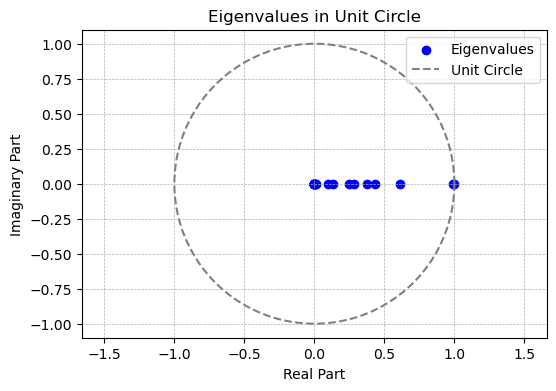

In [26]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [27]:
np.log(real_parts)

C:\Users\Jason\AppData\Local\Temp\ipykernel_34340\2154100952.py:1: RuntimeWarning: invalid value encountered in log
  np.log(real_parts)


array([-1.02721928e-05, -9.78378326e-03, -4.93623350e-01, -8.35568474e-01,
       -9.79887432e-01, -1.25195320e+00, -1.39712216e+00, -2.03818978e+00,
       -2.31789405e+00, -4.27159244e+00, -5.73032575e+00, -6.89217202e+00,
       -8.67067692e+00, -9.38246484e+00, -1.04974293e+01, -1.38309171e+01,
       -1.38309171e+01, -1.45899767e+01, -1.99142040e+01, -2.15456494e+01,
       -2.50159403e+01, -3.00737870e+01,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan])

In [28]:
efuns_real = np.real(efuns)
print(efuns_real.shape)
print(efuns_real)

(16000, 30)
[[-1.07698558e+00 -7.08871875e-03  6.18703402e-02 ... -1.95925784e-04
   2.17570590e-04  2.17570590e-04]
 [-1.07703587e+00 -1.58716463e-02  2.70546123e-02 ...  1.90585428e-05
  -3.45547745e-05 -3.45547745e-05]
 [-1.07712745e+00 -1.89450761e-02 -1.09070224e-02 ...  1.75905049e-06
  -3.06511293e-06 -3.06511293e-06]
 ...
 [-1.07736338e+00  1.48024298e-01 -1.50756469e-02 ... -3.70429104e-06
   7.48277694e-06  7.48277694e-06]
 [-1.07749077e+00  1.51015271e-01 -2.56038555e-02 ... -8.70426486e-06
   1.91336995e-05  1.91336995e-05]
 [-1.07739672e+00  1.49949518e-01 -1.25746430e-02 ...  1.51171609e-06
   3.17716674e-07  3.17716674e-07]]


In [29]:
X.shape

(16000, 2)

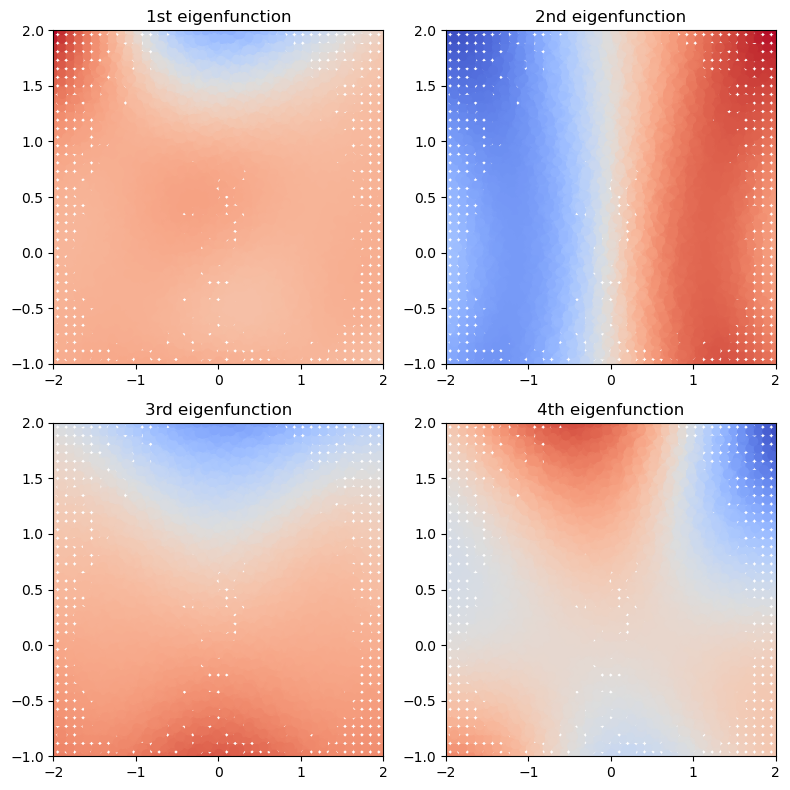

In [30]:
## Plot eigenfunctions
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(ncols=2, nrows=2)

# Plot for the 1st eigenfunction
ax1 = fig.add_subplot(gs[0, 0])#, subplot_kw={"projection": "3d"})
scatter1 = ax1.scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
ax1.set_title('1st eigenfunction')
ax1.set_xlim(-2, 2)  # Correct x-axis limits
ax1.set_ylim(-1, 2)  # Correct y-axis limits

# Plot for the 2nd eigenfunction
ax2 = fig.add_subplot(gs[0, 1])
scatter2 = ax2.scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
ax2.set_title('2nd eigenfunction')
ax2.set_xlim(-2, 2)  # Corrected x-axis limits
ax2.set_ylim(-1, 2)  # Corrected y-axis limits

# Plot for the 3rd eigenfunction
ax3 = fig.add_subplot(gs[1, 0])
scatter3 = ax3.scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
ax3.set_title('3rd eigenfunction')
ax3.set_xlim(-2, 2)  # Corrected x-axis limits
ax3.set_ylim(-1, 2)  # Corrected y-axis limits

# Plot for the 4th eigenfunction
ax4 = fig.add_subplot(gs[1, 1])
scatter4 = ax4.scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
ax4.set_title('4th eigenfunction')
ax4.set_xlim(-2, 2)  # Corrected x-axis limits
ax4.set_ylim(-1, 2)  # Corrected y-axis limits

plt.tight_layout()
plt.show()

In [31]:
# ## Plot eigenfunctions
# # Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# # and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# fig = plt.figure(figsize=(8, 8))
# gs = fig.add_gridspec(ncols=2, nrows=2)

# # Plot for the 1st eigenfunction
# ax1 = fig.add_subplot(gs[0, 0])
# #scatter1 = ax1.scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
# ax.plot_surface(X[:, 0], X[:,1],np.real(efuns)[:, 0], cmap=cm.coolwarm)
                       
# ax1.set_title('1st eigenfunction')
# # ax1.set_xlim(-2, 2)  # Correct x-axis limits
# # ax1.set_ylim(-1, 2)  # Correct y-axis limits

# # Plot for the 2nd eigenfunction
# ax2 = fig.add_subplot(gs[0, 1])
# scatter2 = ax2.scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
# ax2.set_title('2nd eigenfunction')
# ax2.set_xlim(-2, 2)  # Corrected x-axis limits
# ax2.set_ylim(-1, 2)  # Corrected y-axis limits

# # Plot for the 3rd eigenfunction
# ax3 = fig.add_subplot(gs[1, 0])
# scatter3 = ax3.scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
# ax3.set_title('3rd eigenfunction')
# ax3.set_xlim(-2, 2)  # Corrected x-axis limits
# ax3.set_ylim(-1, 2)  # Corrected y-axis limits

# # Plot for the 4th eigenfunction
# ax4 = fig.add_subplot(gs[1, 1])
# scatter4 = ax4.scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
# ax4.set_title('4th eigenfunction')
# ax4.set_xlim(-2, 2)  # Corrected x-axis limits
# ax4.set_ylim(-1, 2)  # Corrected y-axis limits

# plt.tight_layout()
# plt.show()

In [32]:
X[:, 1]

array([-1.        , -0.64093787,  0.27910334, ...,  0.40142926,
        0.60668961,  0.3179211 ])